# Generacion y evaluacion de un algoritmo de clasificacion de texto aplicado los proyectos del repositorio publicos de la comision europea CORDIS

## Libraries

In [1]:

# Configure logging
from datetime import datetime
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.probability import FreqDist
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/javiergarcia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javiergarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/javiergarcia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/javiergarcia/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Read CSV

In [18]:
# Define the file path
non_sci = '/Users/javiergarcia/MANADINE/TFM/data/Classifications_and_Text_Non_Scientific_Projects_20240405.xlsx'

# Read the Excel file
df_non_sci = pd.read_excel(non_sci)

# Display the first few rows of the DataFrame
print(df_non_sci.columns)

Index(['RCN', 'PROJECT_ID_x', 'NON_CATEGORISABLE_AUTO',
       'NON_CATEGORISABLE_MANUAL', 'NON_SCIENTIFIC_SCORE', 'PROJECT_ID_y',
       'FRAMEWORK_PROGRAMME', 'TITLE', 'VALIDATION_DATE', 'ACRONYM',
       'TEXT_VALUE', '_merge'],
      dtype='object')


In [73]:
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Paths to the files
non_sci_path = '/Users/javiergarcia/MANADINE/TFM/data/Classifications_and_Text_Non_Scientific_Projects_20240405.xlsx'
csv_path = '/Users/javiergarcia/MANADINE/TFM/data/Classifications_and_Text_Categories_Validated_Projects-20240405.csv'

# Read the Excel file
df_non_sci = pd.read_excel(non_sci_path)

logging.info('Starting the process')

# Select necessary columns from df_non_sci
df_non_sci = df_non_sci[['PROJECT_ID_x', 'TEXT_VALUE']]
logging.info('Selected columns PROJECT_ID_x and TEXT_VALUE from df_non_sci')

# Add CAT_MANUAL and DOMAIN columns to df_non_sci
df_non_sci['CAT_MANUAL'] = 1
df_non_sci['DOMAIN'] = 'NON_SCIENTIFIC'
logging.info('Added CAT_MANUAL and DOMAIN columns to df_non_sci')

# Read the CSV file
df = pd.read_csv(csv_path)

# Update CAT_MANUAL and DOMAIN columns in df based on NON_SCIENTIFIC_SCORE
df.loc[df['NON_SCIENTIFIC_SCORE'] == 1, 'CAT_MANUAL'] = 1
df.loc[df['NON_SCIENTIFIC_SCORE'] == 1, 'DOMAIN'] = 'NON_SCIENTIFIC'

# Concatenate df_non_sci to df
result_df = pd.concat([df, df_non_sci], ignore_index=True)
logging.info('Concatenated df_non_sci with df')

# Filter and drop duplicates
result_df = result_df[result_df['CAT_MANUAL'] == 1]
result_df = result_df.drop_duplicates(subset=['PROJECT_ID_x', 'DOMAIN', 'CAT_MANUAL'])
logging.info('Filtered and dropped duplicates')

# Display the unique values of DOMAIN and the shape of the resulting dataframe
print(result_df['DOMAIN'].unique())
print(result_df.columns)
print(result_df.shape)
print(len(result_df['PROJECT_ID_x'].unique()))

INFO:root:Starting the process
INFO:root:Selected columns PROJECT_ID_x and TEXT_VALUE from df_non_sci
INFO:root:Added CAT_MANUAL and DOMAIN columns to df_non_sci
/var/folders/2w/910p_vxs6l76rcy48f55tgm80000gn/T/ipykernel_13290/479471224.py:26: DtypeWarning: Columns (2,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
INFO:root:Concatenated df_non_sci with df
INFO:root:Filtered and dropped duplicates


['social sciences' 'engineering and technology' 'natural sciences'
 'humanities' 'agricultural sciences' 'medical and health sciences'
 'NON_SCIENTIFIC']
Index(['REPORT_ID', 'RCN', 'PROJECT_ID_x', 'CAT_MANUAL', 'DOMAIN_SCORE',
       'MAUI_SCORE', 'TF_IDF_SCORE', 'SCORE', 'NOT_TOP5', 'CAT_CODE', 'CAT_ID',
       'PARENT_ID', 'CATEGORY_LABEL_ID', 'DOMAIN', 'LABEL_EN', 'DOC_AUTOMATIC',
       'DOC_MANUAL', 'NON_CATEGORISABLE_AUTO', 'NON_CATEGORISABLE_MANUAL',
       'NON_SCIENTIFIC_SCORE', 'VALIDATION_DATE_x', 'PROJECT_ID_y',
       'FRAMEWORK_PROGRAMME', 'TITLE', 'VALIDATION_DATE_y', 'ACRONYM',
       'TEXT_VALUE'],
      dtype='object')
(16864, 27)
13473


## Preprocessing

In [24]:
def clean_text_column(df, text_column):
    logger.info("Starting text cleaning process...")

    # Create a DataFrame to track the number of words affected or deleted
    changes_df = pd.DataFrame(columns=['Operation', 'Words Before', 'Words After', 'Words Deleted/Affected'])

    def log_changes(operation, words_before, words_after):
        words_deleted = words_before - words_after
        changes_df.loc[len(changes_df)] = [operation, words_before, words_after, words_deleted]

    # Initial word count
    df['original_text'] = df[text_column]
    initial_word_count = df[text_column].apply(lambda x: len(str(x).split())).sum()
    logger.info(f"Initial word count: {initial_word_count}")
    log_changes('Initial', initial_word_count, initial_word_count)

    # Remove rows where the text column is '[NULL]', empty, or NULL
    words_before = df[text_column].apply(lambda x: len(str(x).split())).sum()
    df = df[(df[text_column] != '[NULL]') & (df[text_column].notnull()) & (df[text_column] != '')].copy()
    words_after = df[text_column].apply(lambda x: len(str(x).split())).sum()
    log_changes('Remove [NULL], empty, or NULL rows', words_before, words_after)
    logger.info("Removed rows with '[NULL]', empty, or NULL text values.")

    # Lowercasing
    words_before = words_after
    df.loc[:, 'cleaned_text'] = df[text_column].str.lower()
    words_after = df['cleaned_text'].apply(lambda x: len(str(x).split())).sum()
    log_changes('Lowercasing', words_before, words_after)
    logger.info("Lowercasing completed.")

    # Remove URLs
    words_before = words_after
    df.loc[:, 'cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
    words_after = df['cleaned_text'].apply(lambda x: len(str(x).split())).sum()
    log_changes('Remove URLs', words_before, words_after)
    logger.info("URLs removed.")

    # Remove punctuation, special characters, and numbers
    words_before = words_after
    df.loc[:, 'cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^\w\s]|[\d]', '', x))
    words_after = df['cleaned_text'].apply(lambda x: len(str(x).split())).sum()
    log_changes('Remove Punctuation, Special Characters, and Numbers', words_before, words_after)
    logger.info("Punctuation, special characters, and numbers removed.")

    # Tokenization
    df.loc[:, 'cleaned_text'] = df['cleaned_text'].apply(word_tokenize)
    logger.info("Tokenization completed.")

    # Remove stopwords
    words_before = words_after
    stop_words = set(stopwords.words('english'))
    df.loc[:, 'cleaned_text'] = df['cleaned_text'].apply(lambda x: [word for word in x if word not in stop_words])
    words_after = df['cleaned_text'].apply(lambda x: len(x)).sum()
    log_changes('Remove Stopwords', words_before, words_after)
    logger.info("Stopwords removed.")

    # Remove non-English words
    words_before = words_after
    english_words = set(words.words())
    df.loc[:, 'cleaned_text'] = df['cleaned_text'].apply(lambda x: [word for word in x if word in english_words])
    words_after = df['cleaned_text'].apply(lambda x: len(x)).sum()
    log_changes('Remove Non-English Words', words_before, words_after)
    logger.info("Non-English words removed.")

    # Lemmatization
    words_before = words_after
    lemmatizer = WordNetLemmatizer()
    df.loc[:, 'cleaned_text'] = df['cleaned_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    words_after = df['cleaned_text'].apply(lambda x: len(x)).sum()
    log_changes('Lemmatization', words_before, words_after)
    logger.info("Lemmatization completed.")

    # Snowball Stemmer
    words_before = words_after
    stemmer = SnowballStemmer('english')
    df.loc[:, 'cleaned_text'] = df['cleaned_text'].apply(lambda x: [stemmer.stem(word) for word in x])
    words_after = df['cleaned_text'].apply(lambda x: len(x)).sum()
    log_changes('Stemming', words_before, words_after)
    logger.info("Stemming completed.")
    
    # Join the tokens back into strings
    words_before = words_after
    df.loc[:, 'cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join(x))
    words_after = df['cleaned_text'].apply(lambda x: len(x.split())).sum()
    log_changes('Join Tokens', words_before, words_after)
    logger.info("Tokens joined.")
    
    # Analysis
    df.loc[:, 'word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
    df.loc[:, 'unique_words'] = df['cleaned_text'].apply(lambda x: len(set(x.split())))
    df.loc[:, 'avg_word_length'] = df['cleaned_text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
    
    logger.info("Analysis completed.")
    logger.info("Text cleaning process completed.")
    
    # Display the changes DataFrame for user inspection
    print(changes_df)
    
    return df

In [25]:
cleaned_df = result_df
cleaned_df=clean_text_column(cleaned_df,'TEXT_VALUE')

INFO:__main__:Starting text cleaning process...


INFO:__main__:Initial word count: 4310438
INFO:__main__:Removed rows with '[NULL]', empty, or NULL text values.
INFO:__main__:Lowercasing completed.
INFO:__main__:URLs removed.
INFO:__main__:Punctuation, special characters, and numbers removed.
INFO:__main__:Tokenization completed.
INFO:__main__:Stopwords removed.
INFO:__main__:Non-English words removed.
INFO:__main__:Lemmatization completed.
INFO:__main__:Stemming completed.
INFO:__main__:Tokens joined.
INFO:__main__:Analysis completed.
INFO:__main__:Text cleaning process completed.


                                           Operation  Words Before  \
0                                            Initial       4310438   
1                 Remove [NULL], empty, or NULL rows       4310438   
2                                        Lowercasing       4310138   
3                                        Remove URLs       4310138   
4  Remove Punctuation, Special Characters, and Nu...       4309930   
5                                   Remove Stopwords       4254890   
6                           Remove Non-English Words       2613745   
7                                      Lemmatization       1707733   
8                                           Stemming       1707733   
9                                        Join Tokens       1707733   

   Words After  Words Deleted/Affected  
0      4310438                       0  
1      4310138                     300  
2      4310138                       0  
3      4309930                     208  
4      4254890          

## Split train and test

### Balanced train

In [28]:
from sklearn.model_selection import train_test_split

# Assuming cleaned_df is already defined
X = cleaned_df['cleaned_text']
y = cleaned_df['DOMAIN']

# Calculate the minimum number of samples per class
min_samples_per_class = y.value_counts().min()

# Define the number of samples for the train set (70%)
num_train_samples_per_class = int(min_samples_per_class * 0.7)

# Create empty lists to hold train and test data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Ensure each label has the same number of samples in the training set
for label in y.unique():
    # Extract data for the current label
    label_indices = y[y == label].index
    X_label = X.loc[label_indices]
    y_label = y.loc[label_indices]
    
    # Shuffle the data
    X_label, y_label = X_label.sample(frac=1, random_state=42), y_label.sample(frac=1, random_state=42)
    
    # Ensure the training set has the required number of samples
    X_train_label = X_label[:num_train_samples_per_class]
    y_train_label = y_label[:num_train_samples_per_class]
    
    # Ensure the test set gets the remaining samples
    X_test_label = X_label[num_train_samples_per_class:]
    y_test_label = y_label[num_train_samples_per_class:]
    
    # Append to the lists
    X_train_list.append(X_train_label)
    X_test_list.append(X_test_label)
    y_train_list.append(y_train_label)
    y_test_list.append(y_test_label)

# Concatenate the train and test data
X_train = pd.concat(X_train_list).reset_index(drop=True)
X_test = pd.concat(X_test_list).reset_index(drop=True)
y_train = pd.concat(y_train_list).reset_index(drop=True)
y_test = pd.concat(y_test_list).reset_index(drop=True)

# Log the number of labels in each set
logging.info(f"Number of labels in train set: \n{y_train.value_counts()}")
logging.info(f"Number of labels in test set: \n{y_test.value_counts()}")

INFO:root:Number of labels in train set: 
DOMAIN
social sciences                239
engineering and technology     239
natural sciences               239
humanities                     239
agricultural sciences          239
medical and health sciences    239
NON_SCIENTIFIC                 239
Name: count, dtype: int64
INFO:root:Number of labels in test set: 
DOMAIN
NON_SCIENTIFIC                 6035
natural sciences               3405
engineering and technology     2169
social sciences                1462
medical and health sciences    1242
humanities                      475
agricultural sciences           103
Name: count, dtype: int64


### Unbalanced train

In [59]:
from collections import Counter

# Splitting the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logging label counts
train_label_counts = Counter(y_train)
test_label_counts = Counter(y_test)

# Logging train label counts
logging.info("Train label counts:")
for label, count in train_label_counts.items():
    logging.info(f"{label}: {count}")

# Logging test label counts
logging.info("Test label counts:")
for label, count in test_label_counts.items():
    logging.info(f"{label}: {count}")

INFO:root:Train label counts:
INFO:root:natural sciences: 2509
INFO:root:NON_SCIENTIFIC: 4433
INFO:root:social sciences: 1203
INFO:root:humanities: 498
INFO:root:engineering and technology: 1690
INFO:root:medical and health sciences: 1034
INFO:root:agricultural sciences: 227
INFO:root:Test label counts:
INFO:root:natural sciences: 1135
INFO:root:NON_SCIENTIFIC: 1841
INFO:root:social sciences: 498
INFO:root:medical and health sciences: 447
INFO:root:humanities: 216
INFO:root:engineering and technology: 718
INFO:root:agricultural sciences: 115


# Process the data into Tf-IDF

In [60]:
logging.info("Vectorizing the text data...")
vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.01, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_train.shape

INFO:root:Vectorizing the text data...


(11594,)

## Models
### NAIVE

#### Model

In [112]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, hamming_loss, classification_report, accuracy_score, f1_score, precision_score, recall_score, make_scorer
import matplotlib.pyplot as plt
import logging
import time
import numpy as np

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define the parameter grid with a wider range of values
param_grid = {'estimator__alpha': np.logspace(-5, 1, 200)}

# Initialize the GridSearchCV object with StratifiedKFold and parallel processing
logging.info("Initializing GridSearchCV for multilabel classification...")
multilabel_classifier = OneVsRestClassifier(MultinomialNB())
scoring = {
    'f1': make_scorer(f1_score, average='micro'),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='micro'),
    'recall': make_scorer(recall_score, average='micro')
}

grid_search = GridSearchCV(multilabel_classifier, param_grid, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)

# Measure the start time
start_time = time.time()

# Fit it to the data
logging.info("Fitting the model...")
grid_search.fit(X_train_vectorized, y_train)

# Measure the end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
logging.info(f"Processing time: {processing_time:.2f} seconds")

# Best parameter and classifier
best_alpha = grid_search.best_params_['estimator__alpha']
logging.info(f"Best alpha: {best_alpha}")
nb_classifier = grid_search.best_estimator_

# Predict on the test set with the best classifier
logging.info("Predicting test data...")
y_pred_nb = nb_classifier.predict(X_test_vectorized)

# Evaluate the model
logging.info("Evaluating the model...")
evaluation_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'f1': f1_score(y_test, y_pred_nb, average='micro'),
    'precision': precision_score(y_test, y_pred_nb, average='micro'),
    'recall': recall_score(y_test, y_pred_nb, average='micro'),
    'hamming_loss': hamming_loss(y_test, y_pred_nb)
}

# Print evaluation metrics
for metric, value in evaluation_metrics.items():
    logging.info(f"{metric}: {value:.4f}")

INFO:root:Initializing GridSearchCV for multilabel classification...


INFO:root:Fitting the model...
/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/utils/_response.py", line 203, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of ['NON

#### Evaluation NB

In [110]:
import json
import os

# Evaluation Metrics
logging.info("Calculating evaluation metrics...")
accuracy = accuracy_score(y_test, y_pred_nb)
precision = precision_score(y_test, y_pred_nb, average='macro')
recall = recall_score(y_test, y_pred_nb, average='macro')
f1 = f1_score(y_test, y_pred_nb, average='macro')
ham_loss = hamming_loss(y_test, y_pred_nb)

# Print the overall evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Hamming Loss: {ham_loss}')

# Calculate and print per-label metrics
label_metrics = classification_report(y_test, y_pred_nb, output_dict=True)
df_label_metrics = pd.DataFrame(label_metrics).transpose()
print(df_label_metrics)

# Log the per-label metrics
logging.info(f'Per-label metrics:\n{df_label_metrics}')

# Combine all metrics into a dictionary
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'hamming_loss': ham_loss,
    'per_label_metrics': label_metrics
}

# Generate the timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
filename = f"metrics_NB_UN_{timestamp}.json"

# Define the path to save the JSON file
path = "/Users/javiergarcia/MANADINE/TFM/code/deep_algorithm/Results/Metrics"  # Replace with your actual path
filepath = os.path.join(path, filename)

# Save the metrics dictionary as a JSON file
with open(filepath, 'w') as json_file:
    json.dump(metrics, json_file, indent=4)

# Log the saving of the file
logging.info(f'Metrics saved to {filepath}')

INFO:root:Calculating evaluation metrics...
INFO:root:Per-label metrics:
            precision    recall  f1-score    support
NON_SCI...   0.826775  0.992939  0.902270  1841.0...
agricul...   0.600000  0.052174  0.096000  115.00000
enginee...   0.489824  0.502786  0.496220  718.00000
humanities   0.600962  0.578704  0.589623  216.00000
medical...   0.591022  0.530201  0.558962  447.00000
natural...   0.587629  0.602643  0.595041  1135.0...
social ...   0.510460  0.244980  0.331072  498.00000
accuracy     0.676660  0.676660  0.676660    0.67666
macro avg    0.600953  0.500632  0.509884  4970.0...
weighte...   0.655523  0.676660  0.653092  4970.0...
INFO:root:Metrics saved to /Users/javiergarcia/MANADINE/TFM/code/deep_algorithm/Results/Metrics/metrics_NB_UN_20240525172919.json


Accuracy: 0.6766599597585513
Precision: 0.6009531319198186
Recall: 0.5006323123070463
F1 Score: 0.5098840794455882
Hamming Loss: 0.3233400402414487
            precision    recall  f1-score    support
NON_SCI...   0.826775  0.992939  0.902270  1841.0...
agricul...   0.600000  0.052174  0.096000  115.00000
enginee...   0.489824  0.502786  0.496220  718.00000
humanities   0.600962  0.578704  0.589623  216.00000
medical...   0.591022  0.530201  0.558962  447.00000
natural...   0.587629  0.602643  0.595041  1135.0...
social ...   0.510460  0.244980  0.331072  498.00000
accuracy     0.676660  0.676660  0.676660    0.67666
macro avg    0.600953  0.500632  0.509884  4970.0...
weighte...   0.655523  0.676660  0.653092  4970.0...


### SVM

#### Model

INFO:root:Fitting the model...


INFO:root:Best parameters found: {'estimator__C': 0.1, 'estimator__max_iter': 500, 'estimator__tol': 0.001}


Best parameters: {'estimator__C': 0.1, 'estimator__max_iter': 500, 'estimator__tol': 0.001}


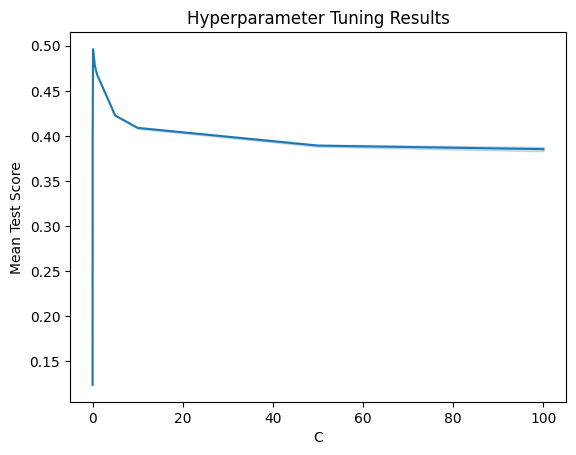

In [132]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, hamming_loss, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import logging
import time

# Define the parameter grid for GridSearchCV
param_grid = {
    'estimator__C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
    'estimator__max_iter': [500, 1000, 2000, 3000, 4000, 5000],
    'estimator__tol': [1e-4, 1e-3, 1e-2]
}

# Wrap LinearSVC with OneVsRestClassifier for multi-label classification
ovr_classifier = OneVsRestClassifier(LinearSVC(dual=False))

# Perform grid search with cross-validation
grid_search = GridSearchCV(ovr_classifier, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Measure the start time
start_time = time.time()

logging.info("Fitting the model...")
grid_search.fit(X_train_vectorized, y_train)

# Measure the end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

# Log the best parameters
best_params = grid_search.best_params_
logging.info(f'Best parameters found: {best_params}')
print("Best parameters:", best_params)

# Use the best estimator to predict on the test set
svm_classifier = grid_search.best_estimator_
y_pred_svm = svm_classifier.predict(X_test_vectorized)

# Analyze results
results = pd.DataFrame(grid_search.cv_results_)
sns.lineplot(x='param_estimator__C', y='mean_test_score', data=results)
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title('Hyperparameter Tuning Results')
plt.show()

#### Evaluation SVM

In [133]:
# Evaluate the model using multiple metrics
logging.info("Calculating evaluation metrics...")
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='macro')
recall = recall_score(y_test, y_pred_svm, average='macro')
f1 = f1_score(y_test, y_pred_svm, average='macro')
ham_loss = hamming_loss(y_test, y_pred_svm)

# Log the evaluation metrics
logging.info(f'Accuracy: {accuracy}')
logging.info(f'Precision: {precision}')
logging.info(f'Recall: {recall}')
logging.info(f'F1 Score: {f1}')
logging.info(f'Hamming Loss: {ham_loss}')
logging.info(f'Processing Time: {processing_time}')

# Calculate and print per-label metrics
label_metrics = classification_report(y_test, y_pred_svm, output_dict=True)
df_label_metrics = pd.DataFrame(label_metrics).transpose()
print(df_label_metrics)

# Log the per-label metrics
logging.info(f'Per-label metrics:\n{df_label_metrics}')

# Combine all metrics into a dictionary
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'hamming_loss': ham_loss,
    'processing_time': processing_time,
    'per_label_metrics': label_metrics
}

# Generate the timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
filename = f"metrics_SVM_UN_{timestamp}.json"

# Define the path to save the JSON file
path = "/Users/javiergarcia/MANADINE/TFM/code/deep_algorithm/Results/Metrics"  # Replace with your actual path
filepath = os.path.join(path, filename)

# Save the metrics dictionary as a JSON file
with open(filepath, 'w') as json_file:
    json.dump(metrics, json_file, indent=4)

# Log the saving of the file
logging.info(f'Metrics saved to {filepath}')

INFO:root:Calculating evaluation metrics...
INFO:root:Accuracy: 0.6732394366197183
INFO:root:Precision: 0.5594059525656864
INFO:root:Recall: 0.5058070844253929
INFO:root:F1 Score: 0.5187916517568911
INFO:root:Hamming Loss: 0.3267605633802817
INFO:root:Processing Time: 154.1147530078888
INFO:root:Per-label metrics:
            precision    recall  f1-score    support
NON_SCI...   0.863787  0.988593  0.921986  1841.0...
agricul...   0.416667  0.130435  0.198675  115.00...
enginee...   0.492176  0.481894  0.486981  718.00...
humanities   0.577114  0.537037  0.556355  216.00...
medical...   0.535047  0.512304  0.523429  447.00...
natural...   0.573995  0.591189  0.582465  1135.0...
social ...   0.457055  0.299197  0.361650  498.00...
accuracy     0.673239  0.673239  0.673239   0.673239
macro avg    0.559406  0.505807  0.518792  4970.0...
weighte...   0.650795  0.673239  0.656986  4970.0...
INFO:root:Metrics saved to /Users/javiergarcia/MANADINE/TFM/code/deep_algorithm/Results/Metrics/metri

            precision    recall  f1-score    support
NON_SCI...   0.863787  0.988593  0.921986  1841.0...
agricul...   0.416667  0.130435  0.198675  115.00...
enginee...   0.492176  0.481894  0.486981  718.00...
humanities   0.577114  0.537037  0.556355  216.00...
medical...   0.535047  0.512304  0.523429  447.00...
natural...   0.573995  0.591189  0.582465  1135.0...
social ...   0.457055  0.299197  0.361650  498.00...
accuracy     0.673239  0.673239  0.673239   0.673239
macro avg    0.559406  0.505807  0.518792  4970.0...
weighte...   0.650795  0.673239  0.656986  4970.0...


### Logistic

#### Model

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, hamming_loss
import logging
import time

# Create the One-vs-Rest logistic regression classifier with a logistic regression base
log_reg = LogisticRegression()
ovr_classifier = OneVsRestClassifier(log_reg)

# Define parameter grid for GridSearchCV
param_grid = {
    'estimator__C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],  # Regularization parameter
    'estimator__solver': ['sag', 'saga'],  # Algorithm to use in the optimization problem
    'estimator__max_iter': [50, 100, 300]  # Maximum number of iterations for solver
}

# Setup GridSearchCV to find the best parameters
grid_search = GridSearchCV(ovr_classifier, param_grid, scoring='accuracy', cv=5)

# Measure the start time
start_time = time.time()

grid_search.fit(X_train_vectorized, y_train)

# Measure the end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

# Log the best parameters
logging.info(f'Best parameters found: {grid_search.best_params_}')
print("Best parameters:", grid_search.best_params_)

# Use the best estimator to predict on the test set
y_pred_log = grid_search.best_estimator_.predict(X_test_vectorized)

/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best parameters: {'estimator__C': 1, 'estimator__max_iter': 300, 'estimator__solver': 'sag'}


#### Evaluation LOG

In [136]:
# Evaluate the model using multiple metrics
logging.info("Calculating evaluation metrics...")
accuracy = accuracy_score(y_test, y_pred_log)
precision = precision_score(y_test, y_pred_log, average='macro')
recall = recall_score(y_test, y_pred_log, average='macro')
f1 = f1_score(y_test, y_pred_log, average='macro')
ham_loss = hamming_loss(y_test, y_pred_log)  # Calculate Hamming Loss

# Log the evaluation metrics
logging.info(f'Accuracy: {accuracy}')
logging.info(f'Precision: {precision}')
logging.info(f'Recall: {recall}')
logging.info(f'F1 Score: {f1}')
logging.info(f'Hamming Loss: {ham_loss}')
logging.info(f'Processing Time: {processing_time}')

# Optionally print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Hamming Loss: {ham_loss}')
print(f'Processing Time: {processing_time}')

# Calculate and print per-label metrics
label_metrics = classification_report(y_test, y_pred_log, output_dict=True)
df_label_metrics = pd.DataFrame(label_metrics).transpose()
print(df_label_metrics)

# Log the per-label metrics
logging.info(f'Per-label metrics:\n{df_label_metrics}')

# Combine all metrics into a dictionary
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'hamming_loss': ham_loss,
    'processing_time': processing_time,
    'per_label_metrics': label_metrics
}

# Generate the timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
filename = f"metrics_LOG_UN_{timestamp}.json"

# Define the path to save the JSON file
path = "/Users/javiergarcia/MANADINE/TFM/code/deep_algorithm/Results/Metrics"  # Replace with your actual path
filepath = os.path.join(path, filename)

# Save the metrics dictionary as a JSON file
with open(filepath, 'w') as json_file:
    json.dump(metrics, json_file, indent=4)

# Log the saving of the file
logging.info(f'Metrics saved to {filepath}')

INFO:root:Calculating evaluation metrics...
INFO:root:Accuracy: 0.6738430583501006
INFO:root:Precision: 0.564526898740593
INFO:root:Recall: 0.5004909964312517
INFO:root:F1 Score: 0.5181709958461747
INFO:root:Hamming Loss: 0.3261569416498994
INFO:root:Processing Time: 415.62123799324036
INFO:root:Per-label metrics:
            precision    recall  f1-score    support
NON_SCI...   0.869275  0.989680  0.925578  1841.0...
agricul...   0.428571  0.130435  0.200000  115.00...
enginee...   0.490754  0.480501  0.485574  718.00...
humanities   0.609195  0.490741  0.543590  216.00...
medical...   0.531017  0.478747  0.503529  447.00...
natural...   0.571788  0.600000  0.585555  1135.0...
social ...   0.451087  0.333333  0.383372  498.00...
accuracy     0.673843  0.673843  0.673843   0.673843
macro avg    0.564527  0.500491  0.518171  4970.0...
weighte...   0.652828  0.673843  0.658682  4970.0...
INFO:root:Metrics saved to /Users/javiergarcia/MANADINE/TFM/code/deep_algorithm/Results/Metrics/metri

Accuracy: 0.6738430583501006
Precision: 0.564526898740593
Recall: 0.5004909964312517
F1 Score: 0.5181709958461747
Hamming Loss: 0.3261569416498994
Processing Time: 415.62123799324036
            precision    recall  f1-score    support
NON_SCI...   0.869275  0.989680  0.925578  1841.0...
agricul...   0.428571  0.130435  0.200000  115.00...
enginee...   0.490754  0.480501  0.485574  718.00...
humanities   0.609195  0.490741  0.543590  216.00...
medical...   0.531017  0.478747  0.503529  447.00...
natural...   0.571788  0.600000  0.585555  1135.0...
social ...   0.451087  0.333333  0.383372  498.00...
accuracy     0.673843  0.673843  0.673843   0.673843
macro avg    0.564527  0.500491  0.518171  4970.0...
weighte...   0.652828  0.673843  0.658682  4970.0...


### Random Forest

#### Model

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, hamming_loss
import logging
import time


logging.info("Starting model training and tuning.")

# Define the model
model = RandomForestClassifier(random_state=42)

# Parameters grid
param_grid = {
    'n_estimators': [50, 100, 200, 999],
    'max_depth': [None, 15, 30, 45],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 7]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Measure the start time
start_time = time.time()

# Fit the grid search to the data
grid_search.fit(X_train_vectorized, y_train)

# Measure the end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

best_model = grid_search.best_estimator_

logging.info("Best parameters found: %s", grid_search.best_params_)

# Predictions
y_pred_rf = best_model.predict(X_test_vectorized)

INFO:root:Starting model training and tuning.


Fitting 3 folds for each of 192 candidates, totalling 576 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  11.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimat

INFO:root:Best parameters found: {'max_depth': 30, 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 999}


#### Evaluation RF

In [68]:
logging.info("Calculating evaluation metrics...")
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='macro')
recall = recall_score(y_test, y_pred_rf, average='macro')
f1 = f1_score(y_test, y_pred_rf, average='macro')
ham_loss = hamming_loss(y_test, y_pred_rf)

report = classification_report(y_test, y_pred_rf)

logging.info("Model evaluation metrics:")
logging.info("Accuracy: %.4f", accuracy)
logging.info("Precision: %.4f", precision)
logging.info("Recall: %.4f", recall)
logging.info("F1 Score: %.4f", f1)
logging.info("Hamming Loss: %.4f", ham_loss)
logging.info("Processing Time: %.4f", processing_time)

# Calculate and print per-label metrics
label_metrics = classification_report(y_test, y_pred_rf, output_dict=True)
df_label_metrics = pd.DataFrame(label_metrics).transpose()
print(df_label_metrics)

# Log the per-label metrics
logging.info(f'Per-label metrics:\n{df_label_metrics}')

# Combine all metrics into a dictionary
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'hamming_loss': ham_loss,
    'processing_time': processing_time,
    'per_label_metrics': label_metrics
}

# Generate the timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
filename = f"metrics_RF_UN_{timestamp}.json"

# Define the path to save the JSON file
path = "/Users/javiergarcia/MANADINE/TFM/code/deep_algorithm/Results/Metrics"  # Replace with your actual path
filepath = os.path.join(path, filename)

# Save the metrics dictionary as a JSON file
with open(filepath, 'w') as json_file:
    json.dump(metrics, json_file, indent=4)

# Log the saving of the file
logging.info(f'Metrics saved to {filepath}')

INFO:root:Calculating evaluation metrics...
/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

                             precision    recall  f1-score      support
NON_SCIENTIFIC                0.719718  0.997284  0.836066  1841.000000
agricultural sciences         0.000000  0.000000  0.000000   115.000000
engineering and technology    0.388462  0.281337  0.326333   718.000000
humanities                    0.431818  0.087963  0.146154   216.000000
medical and health sciences   0.439216  0.250559  0.319088   447.000000
natural sciences              0.434725  0.577974  0.496218  1135.000000
social sciences               0.263736  0.048193  0.081494   498.000000
accuracy                      0.573239  0.573239  0.573239     0.573239
macro avg                     0.382525  0.320473  0.315050  4970.000000
weighted avg                  0.506694  0.573239  0.513380  4970.000000


### Gradient Boosting

##### Model

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, hamming_loss
import time

# Define the model wrapped in OneVsRestClassifier for multilabel classification
gb_classifier = OneVsRestClassifier(GradientBoostingClassifier())

# Define the parameter grid
param_grid = {
    'estimator__learning_rate': [0.2],
    'estimator__n_estimators': [500, 999],
    'estimator__max_depth': [3, 8],
    'estimator__min_samples_split': [10, 20],
    'estimator__min_samples_leaf': [10],
    'estimator__subsample': [1.0],
    'estimator__criterion': ['squared_error']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Measure the start time
start_time = time.time()

# Fit GridSearchCV on the training data
grid_search.fit(X_train_vectorized, y_train)

# Measure the end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

# Best model and parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Predict with the best estimator
y_pred_gb = grid_search.best_estimator_.predict(X_test_vectorized)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'estimator__criterion': 'squared_error', 'estimator__learning_rate': 0.2, 'estimator__max_depth': 3, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 10, 'estimator__n_estimators': 999, 'estimator__subsample': 1.0}
Best cross-validation score: 0.59


#### Evaluation XGB

In [70]:
# Evaluation
logging.info("Calculating evaluation metrics...")
accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb, average='macro')
recall = recall_score(y_test, y_pred_gb, average='macro')
f1 = f1_score(y_test, y_pred_gb, average='macro')
ham_loss = hamming_loss(y_test, y_pred_gb)

# Print the metrics
print("Gradient Boosting Classification Report for Multilabel Problem:")
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Hamming Loss: {ham_loss}')
print(f'Processing Time: {processing_time}')

# Calculate and print per-label metrics
label_metrics = classification_report(y_test, y_pred_gb, output_dict=True)
df_label_metrics = pd.DataFrame(label_metrics).transpose()

# Log the per-label metrics
logging.info(f'Per-label metrics:\n{df_label_metrics}')

# Combine all metrics into a dictionary
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'hamming_loss': ham_loss,
    'processing_time': processing_time,
    'per_label_metrics': label_metrics
}

# Generate the timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
filename = f"metrics_XGB_UN_{timestamp}.json"

# Define the path to save the JSON file
path = "/Users/javiergarcia/MANADINE/TFM/code/deep_algorithm/Results/Metrics"  # Replace with your actual path
filepath = os.path.join(path, filename)

# Save the metrics dictionary as a JSON file
with open(filepath, 'w') as json_file:
    json.dump(metrics, json_file, indent=4)

# Log the saving of the file
logging.info(f'Metrics saved to {filepath}')

INFO:root:Calculating evaluation metrics...


INFO:root:Per-label metrics:
                             precision    recall  f1-score      support
NON_SCIENTIFIC                0.918242  0.976100  0.946288  1841.000000
agricultural sciences         0.246575  0.156522  0.191489   115.000000
engineering and technology    0.321479  0.314763  0.318086   718.000000
humanities                    0.387560  0.375000  0.381176   216.000000
medical and health sciences   0.364486  0.348993  0.356571   447.000000
natural sciences              0.424162  0.423789  0.423975  1135.000000
social sciences               0.240343  0.224900  0.232365   498.000000
accuracy                      0.577666  0.577666  0.577666     0.577666
macro avg                     0.414693  0.402867  0.407136  4970.000000
weighted avg                  0.562860  0.577666  0.569653  4970.000000
INFO:root:Metrics saved to /Users/javiergarcia/MANADINE/TFM/code/deep_algorithm/Results/Metrics/metrics_XGB_UN_20240524134040.json


Gradient Boosting Classification Report for Multilabel Problem:
Accuracy: 0.5776659959758551
Precision: 0.4146926170132903
Recall: 0.40286662132136947
F1 Score: 0.40713587148470426
Hamming Loss: 0.4223340040241449
Processing Time: 12424.68311715126


# Other Analysis

### Unigram Analysis

In [ ]:
# Extract the paragraph from the TEXT_VALUE column (assuming it's the first row)
paragraph = df['TEXT_VALUE'][0]

# Tokenize the paragraph into words
words = word_tokenize(paragraph)

# Calculate frequency distribution
freq_dist = FreqDist(words)

# Get the top 10 most common words and their frequencies, sorted by frequency
top_words_freq = freq_dist.most_common(10)
top_words_freq.sort(key=lambda x: x[1], reverse=False)  # Sort by frequency

# Extract words and frequencies
top_words, frequencies = zip(*top_words_freq)

# Create a bar plot
plt.figure(figsize=(5, 3))
plt.barh(top_words, frequencies, color='royalblue')

# Add titles and labels
plt.title('Top 10 de palabras más frecuentes', fontweight = 'bold')
plt.xlabel('Frecuencia', fontweight = 'bold')
plt.ylabel('palabras', fontweight = 'bold')

# Display the plot
plt.tight_layout()
plt.savefig('/Users/javiergarcia/MANADINE/TFM/Images/Top 10 de palabras más frecuentes.png')
plt.show()

### Brigram analysis

In [ ]:
# Generate bigrams
word_bigrams = list(bigrams(words))

# Calculate frequency distribution of bigrams
bigram_freq_dist = FreqDist(word_bigrams)

# Get the top 10 most common bigrams
top_bigrams = bigram_freq_dist.most_common(10)

# Extract bigram phrases and frequencies
bigram_phrases = [' '.join(bigram) for bigram, _ in top_bigrams]
frequencies = [freq for _, freq in top_bigrams]

# Create a bar plot
plt.figure(figsize=(5, 3))
plt.barh(bigram_phrases, frequencies, color='royalblue')

# Add titles and labels
plt.title('Top 10 de palabras más frecuentes', fontweight = 'bold')
plt.xlabel('Frecuencia', fontweight = 'bold')
plt.ylabel('palabras', fontweight = 'bold')

# Invert y-axis to have the highest frequency on top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.savefig('/Users/javiergarcia/MANADINE/TFM/Images/Top 10 de bigramas más frecuentes.png')
plt.show()

## Result preprocessing

In [ ]:
def frequency_vector(paragraph):
    # Tokenize the paragraph into words
    words = word_tokenize(paragraph)
    
    # Calculate the frequency distribution
    freq_dist = FreqDist(words)
    
    # Create the frequency vector
    freq_vector = {}
    for word, freq in freq_dist.items():
        freq_vector[word] = freq
    
    return freq_vector

# Get the frequency vector
freq_vector = frequency_vector(cleaned_df.loc[0, 'cleaned_text'])

# Print the frequency vector
print("Frequency vector:")
print(freq_vector)

Frequency vector:
{'main': 3, 'aim': 2, 'project': 5, 'acceler': 2, 'transfer': 2, 'metric': 9, 'industri': 6, 'workplac': 2, 'provid': 2, 'enhanc': 2, 'educ': 10, 'current': 3, 'futur': 2, 'use': 4, 'engin': 1, 'measur': 4, 'materi': 3, 'academ': 2, 'packag': 1, 'intend': 1, 'within': 1, 'preliminari': 1, 'survey': 1, 'lead': 1, 'specif': 1, 'modular': 3, 'cours': 2, 'teacher': 2, 'self': 1, 'studi': 1, 'detail': 1, 'structur': 1, 'system': 1, 'avail': 1, 'object': 2, 'produc': 2, 'first': 1, 'phase': 1, 'practic': 1, 'need': 1, 'applic': 1, 'qualiti': 2, 'product': 2, 'associ': 1, 'train': 4, 'determin': 1, 'rang': 2, 'suitabl': 1, 'emphasi': 1, 'set': 1, 'comput': 2, 'learn': 2, 'video': 2, 'also': 2, 'design': 1, 'implement': 1, 'test': 2, 'base': 2, 'teach': 1, 'case': 1, 'data': 1, 'actual': 1, 'formal': 1, 'evalu': 1, 'led': 1, 'number': 1, 'individu': 1, 'uniti': 1, 'nation': 1, 'intern': 1, 'would': 2, 'natur': 1, 'compon': 1, 'environ': 1, 'well': 1, 'wide': 1, 'convent': 1, 

In [ ]:
print(cleaned_df.columns)
print(cleaned_df['DOMAIN'].unique())

Index(['REPORT_ID', 'RCN', 'PROJECT_ID_x', 'CAT_MANUAL', 'DOMAIN_SCORE',
       'MAUI_SCORE', 'TF_IDF_SCORE', 'SCORE', 'NOT_TOP5', 'CAT_CODE', 'CAT_ID',
       'PARENT_ID', 'CATEGORY_LABEL_ID', 'DOMAIN', 'LABEL_EN', 'DOC_AUTOMATIC',
       'DOC_MANUAL', 'NON_CATEGORISABLE_AUTO', 'NON_CATEGORISABLE_MANUAL',
       'NON_SCIENTIFIC_SCORE', 'VALIDATION_DATE_x', 'PROJECT_ID_y',
       'FRAMEWORK_PROGRAMME', 'TITLE', 'VALIDATION_DATE_y', 'ACRONYM',
       'TEXT_VALUE', 'original_text', 'cleaned_text', 'word_count',
       'unique_words', 'avg_word_length'],
      dtype='object')
['social sciences' 'engineering and technology' 'natural sciences'
 'humanities' 'agricultural sciences' 'medical and health sciences'
 'NON_SCIENTIFIC']


INFO:root:Step 1: Analyzing the frequency of 'DOMAIN'


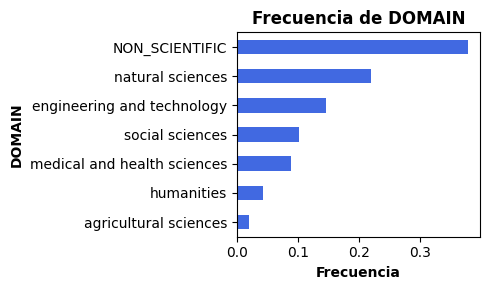

INFO:root:Frequency of 'DOMAIN' bar plot saved as domain_frequency_2024-05-24_14-07-13.png


In [75]:
# Step 1: Analyze the frequency of 'DOMAIN' and create a bar plot
logging.info("Step 1: Analyzing the frequency of 'DOMAIN'")

# Calculate frequency of 'DOMAIN'
domain_freq = cleaned_df['DOMAIN'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(5, 3))
domain_freq.plot(kind='barh', color='royalblue')

# Add titles and labels
plt.title('Frecuencia de DOMAIN', fontweight='bold')
plt.xlabel('Frecuencia', fontweight='bold')
plt.ylabel('DOMAIN', fontweight='bold')

# Invert y-axis to have the highest frequency on top
plt.gca().invert_yaxis()

# Save the current date and time
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define the filename including the current date and time
filename = f'domain_frequency_{current_time}.png'

# Display the plot
plt.tight_layout()
plt.savefig(filename)  # Save the plot
plt.show()

logging.info(f"Frequency of 'DOMAIN' bar plot saved as {filename}")

## Encoding

#### Vector frequences

In [ ]:

import numpy as np
text = 'Este es un ejemplo de un vector de frecuencia que analiza cada objetivo de cada projecto dependiendo de su contenido'

# Tokenize the text into words
words = word_tokenize(text)

# Calculate frequency distribution
freq_dist = FreqDist(words)

# Print each word and its frequency
for word, frequency in freq_dist.items():
    print(word, frequency)


#### One hot encoding

In [ ]:
# Your text
text1 = 'Este es un ejemplo de un vector de frecuencia que analiza cada objetivo de cada projecto dependiendo de su contenido'
text2 = 'Este es otro ejemplo de texto que contiene palabras similares a las del primer ejemplo pero con algunas diferencias'

# Tokenize the text into words
words1 = word_tokenize(text1.lower())  # Convert to lowercase for consistency
words2 = word_tokenize(text2.lower())

# Merge both sets of words into one vocabulary
all_words = sorted(set(words1 + words2))

# Create one-hot encoding vectors
def one_hot_encode(words, vocabulary):
    vector = [1 if word in words else 0 for word in vocabulary]
    return vector

# Create one-hot encoded vectors
vector1 = one_hot_encode(words1, all_words)
vector2 = one_hot_encode(words2, all_words)

# Create a dictionary with words as keys and their one-hot encoded vectors as values
word_vectors = {word: [v1, v2] for word, v1, v2 in zip(all_words, vector1, vector2)}

# Get the one-hot encoding of the second text
one_hot_encoding_text2 = {word: vectors[1] for word, vectors in word_vectors.items()}

print(one_hot_encoding_text2)

In [ ]:
cleaned_df[cleaned_df['DOMAIN']== 'agricultural sciences']['TEXT_VALUE']
pd.set_option('display.max_colwidth',None)
cleaned_df.columns

In [ ]:
cleaned_df[cleaned_df['DOMAIN']== 'agricultural sciences'][['TEXT_VALUE','TITLE']][:1]

In [ ]:
# Count occurrences of each ID in the column 'PROJECT_ID_x'
value_counts = df['PROJECT_ID_x'].value_counts()

# Get the top 5 most frequent values
top_five = value_counts.head(20)

print(top_five)

In [ ]:
filtered_data = df[df['PROJECT_ID_x'] == 101082051]

# Print the filtered data
print(filtered_data)

#### SVM Explanation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from sklearn.preprocessing import StandardScaler
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_and_preprocess_data():
    logging.info("Loading the Iris dataset")
    iris = datasets.load_iris()
    X = iris.data[:, :2]  # Using only the first two features for visualization
    y = iris.target
    logging.info("Preprocessing data: scaling features")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

def train_svm_kernels(X, y):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']  # Add sigmoid kernel
    classifiers = []
    for kernel in kernels:
        logging.info(f"Training SVM with {kernel} kernel")
        if kernel == 'sigmoid':
            clf = svm.SVC(kernel=kernel, gamma='auto')
        else:
            clf = svm.SVC(kernel=kernel, degree=3, gamma='auto')
        clf.fit(X, y)
        classifiers.append(clf)
    return classifiers, kernels

def plot_decision_boundaries(classifiers, kernels, X, y, save_path):
    logging.info("Plotting decision boundaries")
    # Set up the plot grid
    plt.figure(figsize=(12, 8))

    for i, (clf, kernel) in enumerate(zip(classifiers, kernels)):
        plt.subplot(2, 2, i + 1)
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
        plt.title(f'SVM con {kernel} kernel')
        plt.xlabel('Sepal length')
        plt.ylabel('Sepal width')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def main():
    X, y = load_and_preprocess_data()
    classifiers, kernels = train_svm_kernels(X, y)
    save_path = "/Users/javiergarcia/MANADINE/TFM/Images/svm_decision_boundaries.png"  # Specify your path here
    plot_decision_boundaries(classifiers, kernels, X, y, save_path)

if __name__ == '__main__':
    main()


## Databse analysis and descriptives

### Unique values 

In [ ]:
unique_project_ids = cleaned_df['PROJECT_ID_x'].nunique()
print("Number of unique values in PROJECT_ID_x:", unique_project_ids)

### Example of shortest text

In [ ]:
# Sort the DataFrame by the length of 'TEXT_VALUE' in ascending order
sorted_df = cleaned_df.sort_values(by='TEXT_VALUE', key=lambda x: x.str.len())

# Get the top 10 shortest texts
top_10_shortest = sorted_df.head(10)

# Extract the list of shortest texts
top_10_shortest_list = top_10_shortest['TEXT_VALUE'].tolist()

# Print the entire row(s) with the shortest text
print("Top 10 shortest texts:")
print(top_10_shortest)

# Print the list of top 10 shortest texts
print("List of top 10 shortest texts:")
print(top_10_shortest_list)

### Count of domains

INFO:root:Starting the process of counting TEXT_VALUE and plotting the histogram.
INFO:root:Total number of rows in the dataframe: 16564
INFO:root:Count of TEXT_VALUE by DOMAIN:
                        DOMAIN  TEXT_VALUE_COUNT
0               NON_SCIENTIFIC              6274
5             natural sciences              3644
2   engineering and technology              2408
6              social sciences              1701
4  medical and health sciences              1481
3                   humanities               714
1        agricultural sciences               342


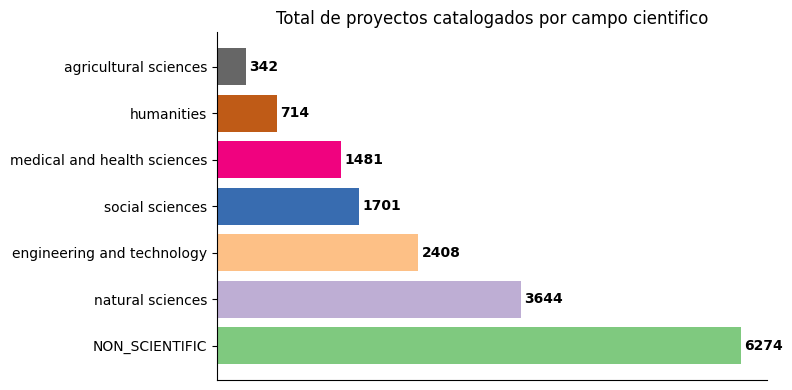

In [74]:
# Log the start of the process
logging.info("Starting the process of counting TEXT_VALUE and plotting the histogram.")

# Count the total number of rows
total_rows = len(cleaned_df)
logging.info(f"Total number of rows in the dataframe: {total_rows}")

# Count the number of rows for the column TEXT_VALUE
text_value_counts = cleaned_df.groupby('DOMAIN')['TEXT_VALUE'].count().reset_index()
text_value_counts.columns = ['DOMAIN', 'TEXT_VALUE_COUNT']

# Sort the counts in descending order
text_value_counts = text_value_counts.sort_values(by='TEXT_VALUE_COUNT', ascending=False)

# Log the count results
logging.info(f"Count of TEXT_VALUE by DOMAIN:\n{text_value_counts}")

# Define pastel colors and create a color mapping for domains
unique_domains = text_value_counts['DOMAIN'].unique()
colors = plt.cm.Accent(np.linspace(0, 1, len(unique_domains)))
color_mapping = dict(zip(unique_domains, colors))

# Plotting the first graph
plt.figure(figsize=(8,4))
bars = plt.barh(text_value_counts['DOMAIN'], text_value_counts['TEXT_VALUE_COUNT'], color=[color_mapping[domain] for domain in text_value_counts['DOMAIN']])

# Setting labels and title
plt.title('Total de proyectos catalogados por campo cientifico')

# Remove x-axis and gridlines
plt.gca().xaxis.set_visible(False)
plt.grid(False)

# Remove the frame (spines) of the graph
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels at the end of the bars with some space and bold text
for bar in bars:
    width = bar.get_width()
    plt.text(width + 40, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='left', fontweight='bold')

# Adjust layout to avoid cutting off labels
plt.tight_layout()

# Save the plot as an image file
plt.savefig('/Users/javiergarcia/MANADINE/TFM/Images/text_value_by_domain.png')

# Show the plot
plt.show()


### Histograms per domain

INFO:root:Completed the process and generated the first histogram plot.
INFO:root:Counting words in TEXT_VALUE column.
INFO:root:Median of word count: 275.0


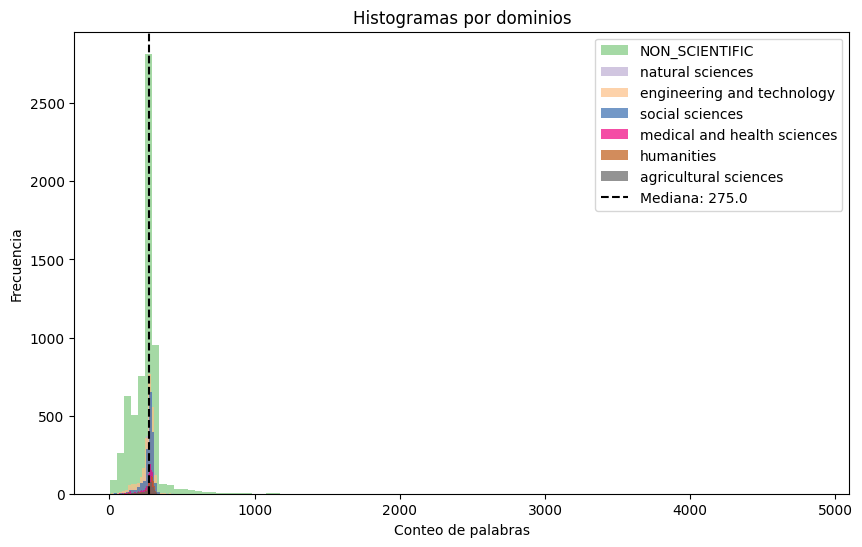

INFO:root:Histograms have been generated and displayed.


In [76]:
# Log the end of the process
logging.info("Completed the process and generated the first histogram plot.")

# Function to count words
def count_words(text):
    return len(text.split())

logging.info("Counting words in TEXT_VALUE column.")
cleaned_df['WORD_COUNT'] = cleaned_df['TEXT_VALUE'].apply(count_words)

# Plotting histograms for the second graph
plt.figure(figsize=(10, 6))

for domain in unique_domains:
    domain_df = cleaned_df[cleaned_df['DOMAIN'] == domain]
    plt.hist(domain_df['WORD_COUNT'], bins=99, alpha=0.7, color=color_mapping[domain], label=domain)

plt.xlabel('Conteo de palabras')
plt.ylabel('Frecuencia')
plt.title('Histogramas por dominios')
plt.legend(title='Domain')

# Calculate median of word count
median_word_count = np.median(cleaned_df['WORD_COUNT'])

# Log median word count
logging.info(f"Median of word count: {median_word_count}")

# Plot a dashed line for the median
plt.axvline(x=median_word_count, color='black', linestyle='--', label=f'Mediana: {median_word_count}')
plt.legend()

# Save the plot as an image file
plt.savefig('/Users/javiergarcia/MANADINE/TFM/Images/domain_histograms.png')

plt.show()

logging.info("Histograms have been generated and displayed.")

### Boxplot

INFO:root:Counting the number of words in TEXT_VALUE for each entry.
INFO:root:Unique DOMAIN values found: ['social sciences' 'engineering and technology' 'natural sciences'
 'humanities' 'agricultural sciences' 'medical and health sciences'
 'NON_SCIENTIFIC']


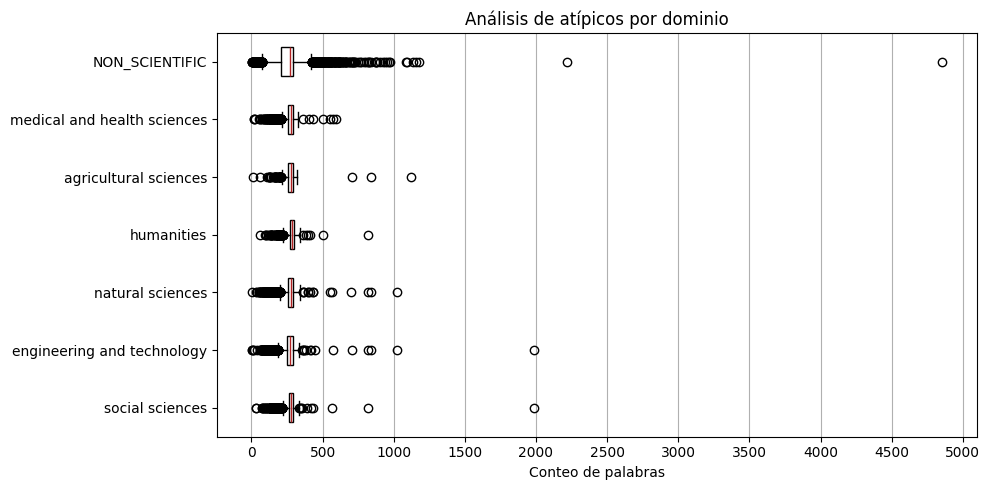

INFO:root:All boxplots created successfully in a single figure.


In [77]:
logging.info("Counting the number of words in TEXT_VALUE for each entry.")
cleaned_df['WORD_COUNT'] = cleaned_df['TEXT_VALUE'].apply(lambda x: len(x.split()))

# Get the unique values in DOMAIN
unique_domains = cleaned_df['DOMAIN'].unique()
logging.info(f"Unique DOMAIN values found: {unique_domains}")

# Prepare data for boxplot
data_to_plot = [cleaned_df[cleaned_df['DOMAIN'] == domain]['WORD_COUNT'] for domain in unique_domains]

# Create the boxplot
plt.figure(figsize=(10, 5))
boxprops = dict(facecolor='w', color='k')
medianprops = dict(color='firebrick')

# Generate the boxplot with patch_artist=True for custom coloring
plt.boxplot(data_to_plot, patch_artist=True, boxprops=boxprops, medianprops=medianprops, vert=False)

# Set the y-ticks to the unique domain names
plt.yticks(np.arange(1, len(unique_domains) + 1), unique_domains)

# Set labels and title
plt.xlabel('Conteo de palabras')
plt.title('Análisis de atípicos por dominio')

# Adding grid
max_word_count = cleaned_df['WORD_COUNT'].max()
plt.xticks(np.arange(0, max_word_count + 500, 500))
plt.grid(True, axis='x')

# Remove the frame (spines) of the graph
#plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

# Adjust layout to avoid cutting off labels
plt.tight_layout()

# Save the plot as an image file
plt.savefig('/Users/javiergarcia/MANADINE/TFM/Images/boxplots.png')

# Show the plot
plt.show()

logging.info("All boxplots created successfully in a single figure.")

### Hypotheses tests

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from scipy.stats import shapiro, normaltest, ttest_ind

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Assuming cleaned_df is already loaded
# cleaned_df = pd.read_csv('path_to_cleaned_df.csv')

# Create a new column for word count
cleaned_df['WORD_COUNT'] = cleaned_df['TEXT_VALUE'].apply(lambda x: len(str(x).split()))

# Get unique domains
domains = cleaned_df['DOMAIN'].unique()
logging.info(f'Found {len(domains)} unique domains')

# Normality tests
normality_results = {}
for domain in domains:
    word_counts = cleaned_df[cleaned_df['DOMAIN'] == domain]['WORD_COUNT']
    stat, p_value = shapiro(word_counts)
    normality_results[domain] = (stat, p_value)
    logging.info(f'Shapiro test for DOMAIN {domain}: stat={stat}, p_value={p_value}')

# Test for significant differences between means
mean_tests = {}
for i, domain1 in enumerate(domains):
    for j, domain2 in enumerate(domains):
        if i < j:
            word_counts1 = cleaned_df[cleaned_df['DOMAIN'] == domain1]['WORD_COUNT']
            word_counts2 = cleaned_df[cleaned_df['DOMAIN'] == domain2]['WORD_COUNT']
            stat, p_value = ttest_ind(word_counts1, word_counts2)
            mean_tests[(domain1, domain2)] = (stat, p_value)
            logging.info(f'T-test between DOMAIN {domain1} and DOMAIN {domain2}: stat={stat}, p_value={p_value}')




INFO:root:Found 7 unique domains
INFO:root:Shapiro test for DOMAIN social sciences: stat=0.45958911676974923, p_value=1.0509589116030836e-57
INFO:root:Shapiro test for DOMAIN engineering and technology: stat=0.5868007152701442, p_value=5.346632572252473e-60
INFO:root:Shapiro test for DOMAIN natural sciences: stat=0.744795190070394, p_value=1.1427543936337547e-59
INFO:root:Shapiro test for DOMAIN humanities: stat=0.7221675913506485, p_value=8.84934498686478e-33
INFO:root:Shapiro test for DOMAIN agricultural sciences: stat=0.5001155544015361, p_value=6.452863639740623e-30
INFO:root:Shapiro test for DOMAIN medical and health sciences: stat=0.7794399796241104, p_value=9.641813765089515e-41
/Users/javiergarcia/MANADINE/TFM/.venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6274.
  res = hypotest_fun_out(*samples, **kwds)
INFO:root:Shapiro test for DOMAIN NON_SCIENTIFIC: sta

In [ ]:
cleaned_df['DOMAIN'].unique()

### Correlation Matrix

INFO:root:One-hot encoding DOMAIN column
INFO:root:Calculating the correlation matrix
INFO:root:Correlation matrix:
                             NON_SCIENTIFIC  agricultural sciences  \
NON_SCIENTIFIC                     1.000000              -0.113377   
agricultural sciences             -0.113377               1.000000   
engineering and technology        -0.322049              -0.059885   
humanities                        -0.165729              -0.030817   
medical and health sciences       -0.244680              -0.045498   
natural sciences                  -0.414689              -0.077111   
social sciences                   -0.264158              -0.049120   

                             engineering and technology  humanities  \
NON_SCIENTIFIC                                -0.322049   -0.165729   
agricultural sciences                         -0.059885   -0.030817   
engineering and technology                     1.000000   -0.087537   
humanities                             

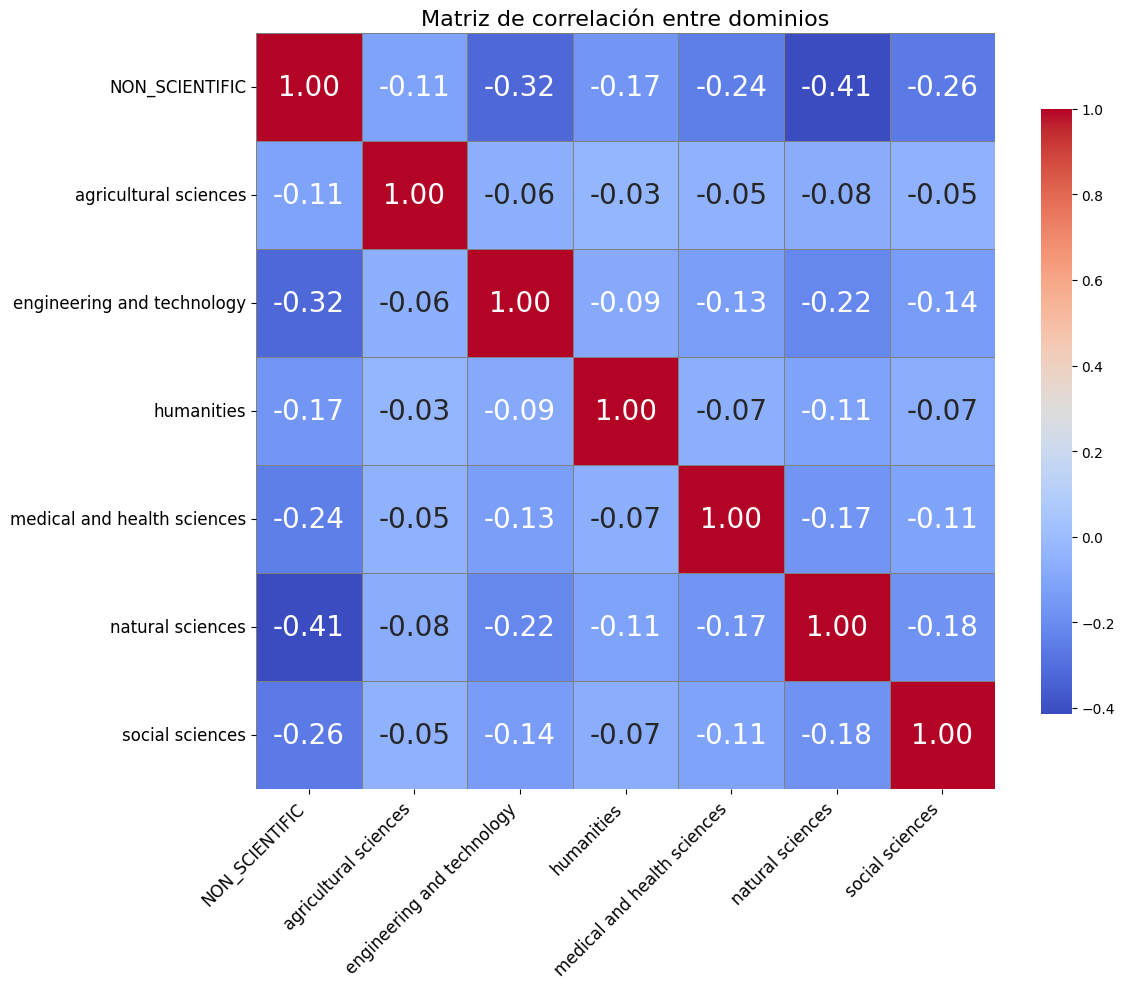

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the DOMAIN column
logging.info("One-hot encoding DOMAIN column")
encoder = OneHotEncoder(sparse_output=False)
domain_encoded = encoder.fit_transform(cleaned_df[['DOMAIN']])

# Create a DataFrame with one-hot encoded values
domain_df = pd.DataFrame(domain_encoded, columns=encoder.categories_[0], index=cleaned_df.index)

# Calculate the correlation matrix
logging.info("Calculating the correlation matrix")
correlation_matrix = domain_df.corr()

# Log the correlation matrix
logging.info(f"Correlation matrix:\n{correlation_matrix}")

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                      xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns,
                      cbar_kws={'shrink': 0.8}, linewidths=0.5, linecolor='gray',
                      annot_kws={"size": 20})  # Adjusted annotation size

# Rotate x-axis labels by 45 degrees
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to avoid cutting off labels
plt.title('Matriz de correlación entre dominios', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot as an image file
plt.savefig('/Users/javiergarcia/MANADINE/TFM/Images/correlation_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

### Preprocess Analysis

In [80]:
# Set pandas display options to show full text content
pd.set_option('display.max_colwidth', None)
print(cleaned_df[cleaned_df['PROJECT_ID_x']== 101138040][['original_text','cleaned_text']])
pd.set_option('display.max_colwidth', 10)

### preprocessing per label
# Function to count words in a text
def count_words(text):
    return len(text.split())

# Group by domain and calculate the required metrics
domain_analysis = cleaned_df.groupby('DOMAIN').agg({
    'original_text': lambda x: sum(x.apply(count_words)),
    'cleaned_text': lambda x: sum(x.apply(count_words)),
}).rename(columns={
    'original_text': 'Total Original Words',
    'cleaned_text': 'Total Cleaned Words'
})

domain_analysis['Unique Original Words'] = cleaned_df.groupby('DOMAIN')['original_text'].apply(lambda x: len(set(" ".join(x).split())))
domain_analysis['Unique Cleaned Words'] = cleaned_df.groupby('DOMAIN')['cleaned_text'].apply(lambda x: len(set(" ".join(x).split())))

domain_analysis

,Total Original Words,Total Cleaned Words,Unique Original Words,Unique Cleaned Words
DOMAIN,,,,
NON_SCIENTIFIC,1575705,588800,81551,6827
agricultural sciences,92827,38198,15353,3608
engineering and technology,629511,258088,56787,7348
humanities,197270,77742,26279,5194
medical and health sciences,392375,162183,39816,6360
natural sciences,961601,396215,75489,9365
social sciences,460849,186507,45564,6817


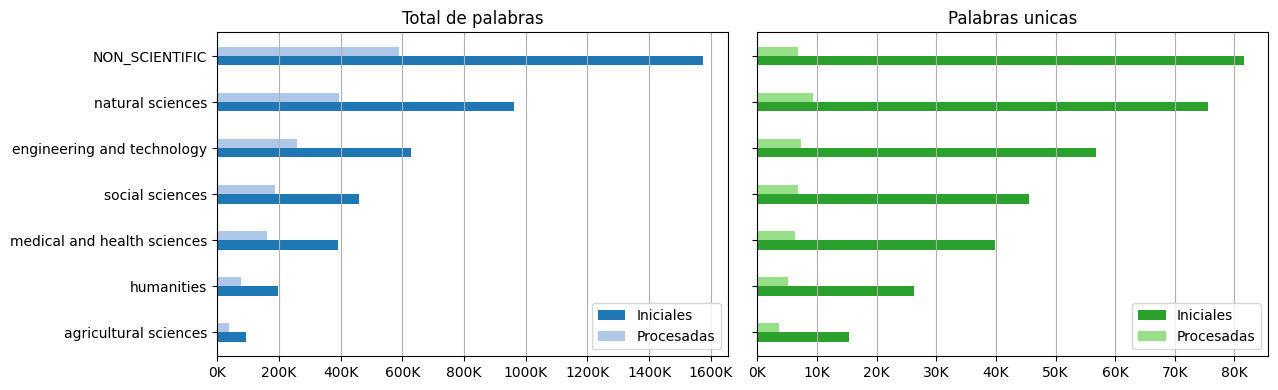

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def thousands_formatter(x, pos):
    return '%1.0fK' % (x * 1e-3)

# Sort the DataFrame in descending order based on 'Total Original Words'
domain_analysis = domain_analysis.sort_values(by='Total Original Words', ascending=True)

# Parameters
bar_width = 0.2
indices = range(len(domain_analysis))

# Using Set2 palette from seaborn
palette = sns.color_palette("tab20", 6)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14, 4))

# Positions for each group of bars
pos1 = [i for i in indices]
pos2 = [i + bar_width for i in indices]

# Plot for Total Words
ax1.barh(pos1, domain_analysis['Total Original Words'], bar_width, label='Iniciales', color=palette[0])
ax1.barh(pos2, domain_analysis['Total Cleaned Words'], bar_width, label='Procesadas', color=palette[1])

# Customizing the graph
ax1.set_title('Total de palabras')
ax1.set_yticks([bar_width for r in range(len(domain_analysis))])
ax1.set_yticklabels(domain_analysis.index)
ax1.legend(loc= 'lower right')

# Disable scientific notation and set custom formatter
ax1.ticklabel_format(style='plain', axis='x')
ax1.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Add grid lines to x-axis
ax1.xaxis.grid(True)

# Sort the DataFrame in descending order based on 'Unique Original Words'
domain_analysis = domain_analysis.sort_values(by='Unique Original Words', ascending=True)

# Positions for each group of bars
pos3 = [i for i in indices]
pos4 = [i + bar_width for i in indices]

# Plot for Unique Words
ax2.barh(pos3, domain_analysis['Unique Original Words'], bar_width, label='Iniciales', color=palette[4])
ax2.barh(pos4, domain_analysis['Unique Cleaned Words'], bar_width, label='Procesadas', color=palette[5])

# Customizing the graph
ax2.set_title('Palabras unicas')
ax2.set_yticks([r + bar_width/2 for r in range(len(domain_analysis))])
ax2.set_yticklabels(domain_analysis.index)
ax2.legend(loc= 'lower right')

# Disable scientific notation and set custom formatter
ax2.ticklabel_format(style='plain', axis='x')
ax2.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Add grid lines to x-axis
ax2.xaxis.grid(True)

plt.tight_layout(rect=[0.08, 0, 1, 1])

# Save the plot as an image file
plt.savefig('/Users/javiergarcia/MANADINE/TFM/Images/preprocess.png', dpi=300, bbox_inches='tight')

plt.show()

## Multilabel projects

In [194]:
df[df['PROJECT_ID_x']==101035792][['PROJECT_ID_x','CAT_MANUAL','DOMAIN']]

,PROJECT_ID_x,CAT_MANUAL,DOMAIN
34207,101035792,1.0,social...
34208,101035792,1.0,medica...


## Models hiperparameters

### NB

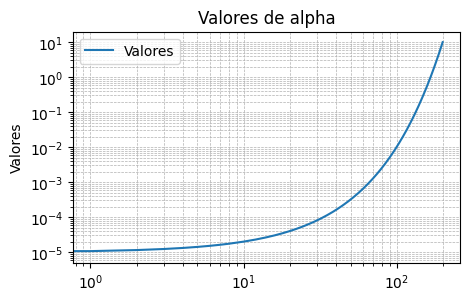

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Generate logspace values
x = np.logspace(-5, 1, 200)

# Plot the values
plt.figure(figsize=(5, 3))
plt.plot(x, label='Valores')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Valores')
plt.title('Valores de alpha')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Save the plot as an image file
plt.savefig('/Users/javiergarcia/MANADINE/TFM/Images/parameters_NV.png', dpi=300, bbox_inches='tight')
plt.show()

### SVM

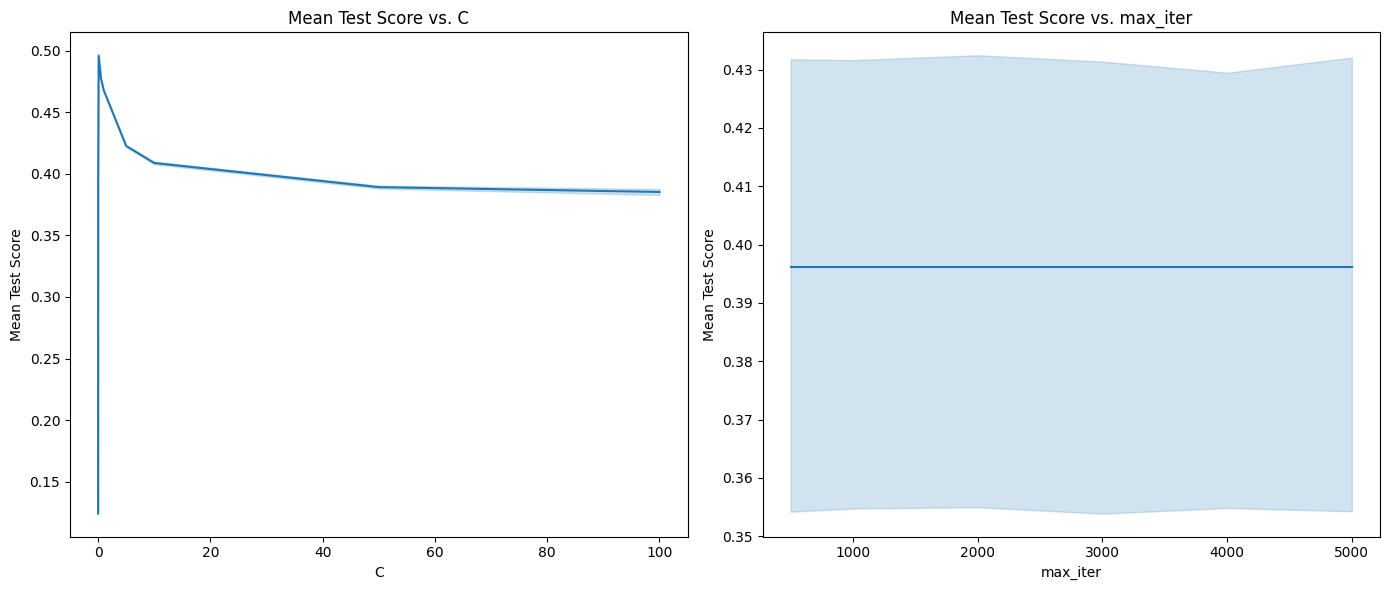

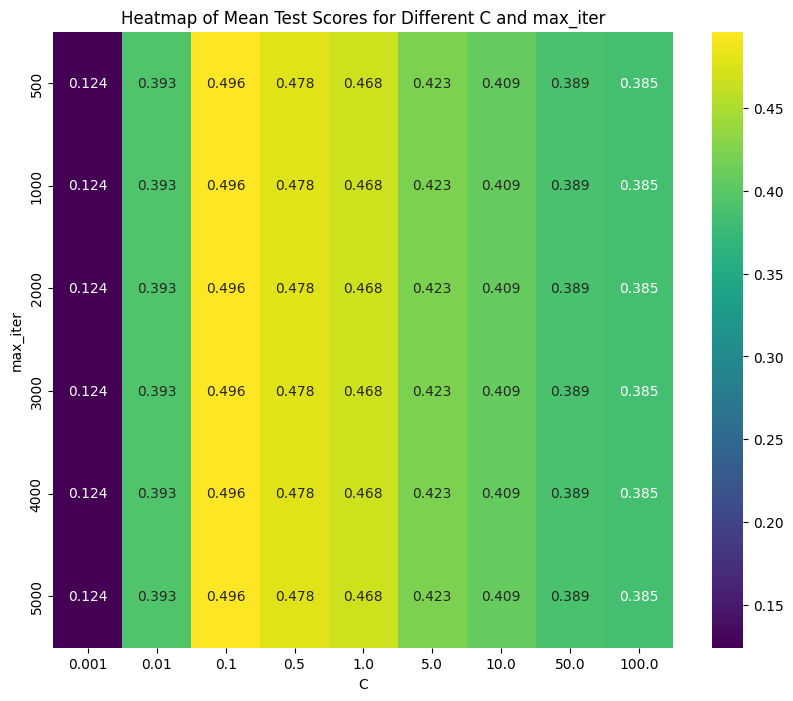

In [131]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, hamming_loss, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import logging
import time

# Analyze results
results = pd.DataFrame(grid_search.cv_results_)

# Plot mean test scores for different values of C and max_iter
plt.figure(figsize=(14, 6))

# Line plot for C values
plt.subplot(1, 2, 1)
sns.lineplot(data=results, x='param_estimator__C', y='mean_test_score')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. C')

# Line plot for max_iter values
plt.subplot(1, 2, 2)
sns.lineplot(data=results, x='param_estimator__max_iter', y='mean_test_score')
plt.xlabel('max_iter')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. max_iter')

plt.tight_layout()
plt.show()

# Heatmap for the combination of C and max_iter
pivot_table = results.pivot_table(values='mean_test_score', index='param_estimator__max_iter', columns='param_estimator__C')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.xlabel('C')
plt.ylabel('max_iter')
plt.title('Heatmap of Mean Test Scores for Different C and max_iter')
plt.show()